# Homework_iii

In [1]:
import sys

In [2]:
sys.path.append('/Users/wenjincao/Desktop/Homework')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/hm_ii')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/hm_ii/FIRE_pytools')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/hm_ii/FIRE_pytools/utils')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/hm_ii/FIRE_pytool/import_kf')
sys.path.append('/Users/wenjincao/Desktop/Homework/LM_folder/homeworks/hm_ii/FIRE_pytools/data_setup')

In [3]:
from homeworks.hm_ii.FIRE_pytools.utils.monthly_date import *
from homeworks.hm_ii.FIRE_pytools.portools.find_breakpoints import find_breakpoints
from homeworks.hm_ii.FIRE_pytools.portools.sort_portfolios import sort_portfolios

In [4]:
from homeworks.hm_ii.FIRE_pytools.import_kf.kf_factors import *

/Users/wenjincao/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [5]:
import homeworks.hm_ii.FIRE_pytools.data_setup.stock_annual as stock_annual
import homeworks.hm_ii.FIRE_pytools.data_setup.stock_monthly as stock_monthly

In [6]:
desired_width = 10
pd.set_option('display.width', desired_width)
idx = pd.IndexSlice

In [7]:
# %% Set Up

char_breakpoints = {'me': [0.5],
                    'beme': [0.3, 0.7],
                    'opbe': [0.3, 0.7],
                    'inv': [0.3, 0.7]}

weightvar = 'melag_weights'

retvar = 'retadj'

dict_factors = {'beme': 'hml',
                'me': 'smb',
                'opbe': 'rmw',
                'inv': 'cma'}


In [8]:
# %% Download Data
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100

# Annual Data

varlist = ['conm', 'fyear', 'fyr', 'at', 'capx', 'ceq', 'cogs', 'dlc', 'ib', 'icapt', 'itcb', 'lt', 'mib',
            'naicsh', 'pstk', 'pstkl', 'pstkrv',  'sale', 'seq', 'sich', 'sstk', 'txdb', 'txdi', 'txditc',
            'xint', 'xsga']
adata = stock_annual.main(varlist=varlist, complete_table=False)

# Monthly Data
mdata = stock_monthly.main()

Stock annual calculation started.
Enter your WRDS username [wenjincao]:wcwenjin
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done
Compustat data was successfully downloaded in 16.36748504638672 seconds.
Pension data was successfully downloaded in 0.9325942993164062 seconds.
CRSP data was successfully downloaded in 86.49891805648804 seconds.
CRSP and Compsuat merge created 6 (fyear, permno) duplicates.
Keeping only the last available datadate per PERMNO.
There are 81664 PERMNOs without a valid PERMCO in DFF BE data: not present in the stock names table.
Number of not valid PERMCOs in lcomp: 0
Number of entries with valis sich:
0.0457
Number of entries with valis sich_filled:
0.003
Time to create stock_annual: 167.00015497207642 seconds
Stock monthly calculation started.
Enter your WRDS username [wenjincao]:wcwenjin
Enter your password:········
WRD

In [9]:
# Set names
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) #inv_permco
mdata.rename(columns={weightvar: 'weightvar', retvar: 'retvar'}, inplace=True)

In [73]:
# %% Create Filters
# Global Filters: applied to all portfolio sorts

# valid return
# ------------
print('Data deleted due to missing return: %f' % np.round(mdata.retvar.isnull().mean()*100, 2))
rdata = mdata[mdata.retvar.notnull()]

# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]

#del adata, mdata

Data deleted due to missing return: 3.310000
Data deleted due to shrcd: 23.390000
Data deleted due to exchcd: 1.560000


In [11]:
# Portfolio Specif Filters
sortvars = [*char_breakpoints]

# Define the break point filters
# ------------------------------
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

# Define the sample filter
# ------------------------
sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    # notice that the way we defined beme or beme is null if be<=0
    bp_filters[sortvar] = (sort_data[sortvar].notnull())
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0) & (sort_data[sortvar].notnull()))

# %% Find Breakpoints
# The number of firms Ken French reports for each characteristic sort varies. This means his universe of stocks
# for sorting changes across characteristics. That is why we need to calculate breakpoints separately.
breakpoints = [None] * len(sortvars)
breakpoints = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    breakpoints[sortvar] = find_breakpoints(data=sort_data[bp_filters[sortvar]],
                                            quantiles={sortvar: char_breakpoints[sortvar]},
                                            id_variables=['rankyear', 'permno', 'exchcd'],
                                            exch_cd=[1]
                                            )

# %% Portfolio Sorts
portsorts = [None] * len(sortvars)
portsorts = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    portsorts[sortvar] = sort_portfolios(data=sort_data[sample_filters[sortvar]],
                                         quantiles={sortvar: char_breakpoints[sortvar]},
                                         id_variables=['rankyear', 'permno', 'exchcd'],
                                         breakpoints={sortvar: breakpoints[sortvar]}
                                         )

# merge all separate portfolio allocations together
port = portsorts['me'].copy()
for sortvar in sortvars[1:]:
    # Notice that this is an outer join
    port = port.merge(portsorts[sortvar], on=['permno', 'rankyear'], how='outer')

# %% Calculate rertuns
# Notice that this is a inner join
port_ret = pd.merge(port, rdata, on=['rankyear', 'permno'])

NYSE breakpoints were calculated for me.
NYSE breakpoints were calculated for beme.
NYSE breakpoints were calculated for opbe.
NYSE breakpoints were calculated for inv.
Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1926.0
Stocks were sorted according to breakpoints, starting in 1951.0
Stocks were sorted according to breakpoints, starting in 1952.0


## Calculate Factor Returns

Follow the definition of SMB, HML, RMW and CMA from Ken French's website [here](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html).

The first step is to calculate the monthly returns of 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment. The portfolio weights should be melag.

The second step is to calculate the factor returns. 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [116]:
fdata_1 = port_ret.copy()

In [117]:
ret_beme = pd.DataFrame()
ret_opbe = pd.DataFrame()
ret_inv = pd.DataFrame()
rets = dict()

for var in ['beme','opbe','inv']:
    fdata = fdata_1[fdata_1.lag_me.notnull()].copy()
    fdata = fdata[fdata.retvar.notnull()].copy()
    fdata = fdata.groupby(['date','meportfolio',f'{var}portfolio'])\
                .apply(lambda x: np.average(x['retvar'], weights = x["lag_me"]))
    fdata = fdata.unstack(level = [1,2])
    if var == 'beme':
        ret_beme = fdata
    elif var == 'opbe':
        ret_opbe = fdata
    else:
        ret_inv = fdata

rets = {'beme':ret_beme,'opbe': ret_opbe, 'inv':ret_inv}

In [118]:
for var, retn in rets.items():
    rets[var] = retn['1963':'2019']

In [119]:
rets

{'beme': meportfolio         me1  \
 bemeportfolio     beme1   
 date                      
 1963-01-31     0.079098   
 1963-02-28    -0.034531   
 1963-03-29    -0.001690   
 1963-04-30     0.035086   
 1963-05-31     0.013856   
 ...                 ...   
 2019-08-30    -0.041228   
 2019-09-30    -0.024214   
 2019-10-31     0.043715   
 2019-11-29     0.063463   
 2019-12-31     0.033320   
 
 meportfolio              \
 bemeportfolio     beme2   
 date                      
 1963-01-31     0.079436   
 1963-02-28    -0.014965   
 1963-03-29     0.016063   
 1963-04-30     0.038171   
 1963-05-31     0.032056   
 ...                 ...   
 2019-08-30    -0.061450   
 2019-09-30     0.042230   
 2019-10-31     0.022033   
 2019-11-29     0.030811   
 2019-12-31     0.038636   
 
 meportfolio              \
 bemeportfolio     beme3   
 date                      
 1963-01-31     0.106987   
 1963-02-28     0.002906   
 1963-03-29     0.017481   
 1963-04-30     0.041196   
 1963-05

In [120]:
plt.style.use('seaborn')

For each one of the the 3 characteristics (BEME, OP and INV), plot the time series of cumulative log-returns for each of the 6 value-weight portfolios (BEME X ME, OP X ME and INV X ME).

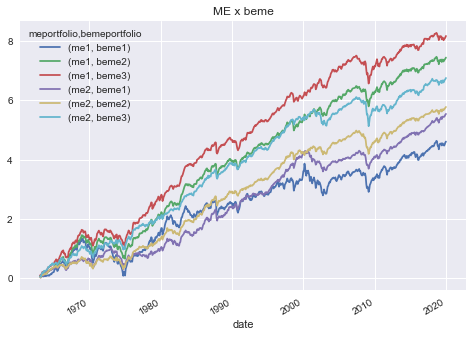

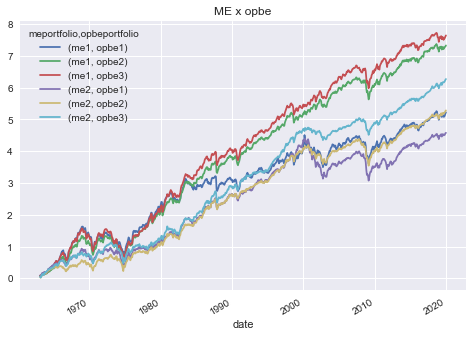

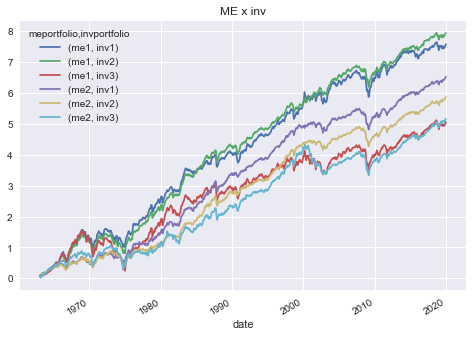

In [121]:
for var, retn in rets.items():
    log_return = np.log(1+retn).cumsum()
    log_return.plot()
    plt.title(f'ME x {var}')
    plt.show

In [122]:
rets['beme'].loc[:,idx[:,]]

meportfolio         me1  \
bemeportfolio     beme1   
date                      
1963-01-31     0.079098   
1963-02-28    -0.034531   
1963-03-29    -0.001690   
1963-04-30     0.035086   
1963-05-31     0.013856   
...                 ...   
2019-08-30    -0.041228   
2019-09-30    -0.024214   
2019-10-31     0.043715   
2019-11-29     0.063463   
2019-12-31     0.033320   

meportfolio              \
bemeportfolio     beme2   
date                      
1963-01-31     0.079436   
1963-02-28    -0.014965   
1963-03-29     0.016063   
1963-04-30     0.038171   
1963-05-31     0.032056   
...                 ...   
2019-08-30    -0.061450   
2019-09-30     0.042230   
2019-10-31     0.022033   
2019-11-29     0.030811   
2019-12-31     0.038636   

meportfolio              \
bemeportfolio     beme3   
date                      
1963-01-31     0.106987   
1963-02-28     0.002906   
1963-03-29     0.017481   
1963-04-30     0.041196   
1963-05-31     0.054072   
...                 ...   
2019-08-30    -0.079859   
2019-09-30     0.056340   
2019-10-31     0.004782   
2019-11-29     0.037223   
2019-12-31     0.051651   

meportfolio         me2  \
bemeportfolio     beme1   
date                      
1963-01-31     0.048562   
1963-02-28    -0.024451   
1963-03-29     0.033710   
1963-04-30     0.047744   
1963-05-31     0.017041   
...                 ...   
2019-08-30    -0.011630   
2019-09-30     0.003026   
2019-10-31     0.025773   
2019-11-29     0.044807   
2019-12-31     0.028033   

meportfolio              \
bemeportfolio     beme2   
date                      
1963-01-31     0.045002   
1963-02-28    -0.019853   
1963-03-29     0.040682   
1963-04-30     0.050086   
1963-05-31     0.017888   
...                 ...   
2019-08-30    -0.031897   
2019-09-30     0.037839   
2019-10-31     0.015394   
2019-11-29     0.033000   
2019-12-31     0.026905   

meportfolio              
bemeportfolio     beme3  
date                     
1963-01-31     0.068257  
1963-02-28    -0.011901  
1963-03-29     0.054295  
1963-04-30     0.057409  
1963-05-31     0.040206  
...                 ...  
2019-08-30    -0.070181  
2019-09-30     0.058564  
2019-10-31     0.024165  
2019-11-29     0.028226  
2019-12-31     0.043162  

[684 rows x 6 columns]

Plot the time series of cumulative log-returns for each of the 3 SMB components, i.e., $SMB_{BEME}$, $SMB_{OP}$ and $SMB_{INV}$.

In [123]:
SMB = {}
for var, retn in rets.items():
    SMB[var] = (retn.loc[:,idx['me1',:]].mean(axis = 1) -\
                retn.loc[:,idx['me2',:]].mean(axis = 1))

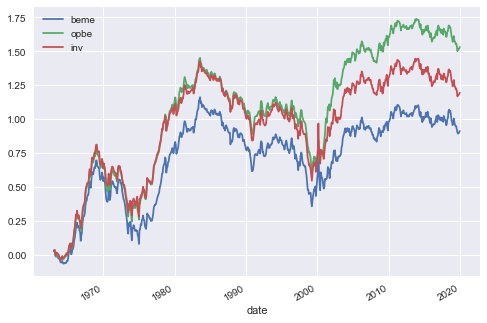

In [124]:
np.log(1+ pd.DataFrame(SMB)).cumsum().plot()

Plot the time series of cumulative log-returns for each of the 4 factors, i.e., SMB, HML, RMW and INV.

In [214]:
all_factors = dict()

for i in ['SMB','HML','RMW','CMA']:
    if i == 'SMB':
        all_factors[i] = pd.DataFrame(SMB).mean(axis = 1)
    elif i == 'HML':
        all_factors[i] = rets['beme'].loc[:,idx[:,'beme3']].mean(axis = 1) - \
                         rets['beme'].loc[:,idx[:,'beme1']].mean(axis = 1)
    elif i == 'RMW':
        all_factors[i] = rets['opbe'].loc[:,idx[:,'opbe3']].mean(axis = 1) - \
                         rets['opbe'].loc[:,idx[:,'opbe1']].mean(axis = 1)
    else:
        all_factors[i] = rets['inv'].loc[:,idx[:,'inv1']].mean(axis = 1) - \
                         rets['inv'].loc[:,idx[:,'inv3']].mean(axis = 1)

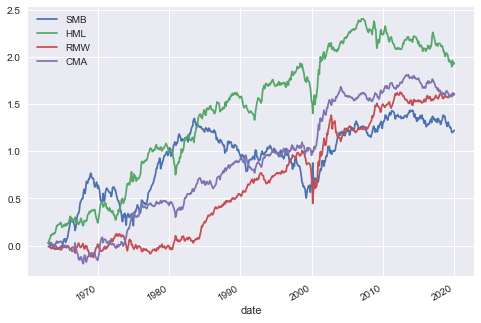

In [215]:
all_factors = pd.DataFrame(all_factors)
np.log(1+all_factors).cumsum().plot()

Compare your factor with the ones reported in Ken French's website. Report the mean, volatility, Sharpe-ratio and correlations.


In [216]:
all_factors.describe()

,SMB,HML,RMW,CMA
count,684.000000,684.000000,684.000000,684.000000
mean,0.002223,0.003231,0.002616,0.002546
std,0.029574,0.028033,0.022594,0.019660
min,-0.150850,-0.121291,-0.187118,-0.065737
25%,-0.014953,-0.013008,-0.008458,-0.010225
50%,0.000901,0.002929,0.002133,0.001215
75%,0.020317,0.017550,0.013041,0.014206
max,0.186065,0.126921,0.143107,0.093706


In [147]:
ff_ret

,Mkt-RF,SMB,HML,RMW,CMA,RF
mdate,,,,,,
196307,-0.0039,-0.0047,-0.0083,0.0066,-0.0115,0.0027
196308,0.0507,-0.0079,0.0167,0.0039,-0.0040,0.0025
196309,-0.0157,-0.0048,0.0018,-0.0076,0.0024,0.0027
196310,0.0253,-0.0129,-0.0010,0.0275,-0.0224,0.0029
196311,-0.0085,-0.0084,0.0171,-0.0045,0.0222,0.0027
...,...,...,...,...,...,...
201909,0.0144,0.0032,0.0671,0.0197,0.0355,0.0018
201910,0.0206,0.0021,-0.0207,0.0043,-0.0096,0.0015
201911,0.0387,0.0050,-0.0186,-0.0150,-0.0129,0.0012


In [209]:
all_factors_mean = []
all_factors_std = []
all_factors_sharpe_ratio = []
all_factors.dropna(inplace = True)

for i in ['SMB','HML','RMW','CMA']:
    all_factors_mean.append(all_factors.loc[:, i].mean())
    all_factors_std.append(all_factors.loc[:, i].std())
    all_factors_sharpe_ratio.append((all_factors.loc[:, i] - ff_ret['RF']).dropna().mean()/(all_factors.loc[:, i]).std())
    

In [211]:
Self_result = {'Mean':all_factors_mean,'Std Deviation': all_factors_std,\
                           'Sharpe Ratio': all_factors_sharpe_ratio}
Self_result= pd.DataFrame(Self_result)

In [212]:
Self_result

,Mean,Std Deviation,Sharpe Ratio
0,0.002223,0.029574,-0.052488
1,0.003231,0.028033,-0.024889
2,0.002616,0.022594,-0.048576
3,0.002546,0.019660,-0.063869


In [217]:
fama_frech_mean = []
fama_frech_std = []
fama_frech_sharpe_ratio = []

for i in ['SMB','HML','RMW','CMA']:
    fama_frech_mean.append(ff_ret[i].mean())
    fama_frech_std.append(ff_ret[i].std())
    fama_frech_sharpe_ratio.append((ff_ret[i] - ff_ret['RF']).dropna().mean()/(ff_ret[i]).dropna().std())

In [218]:
Fama_frech = {'Mean':fama_frech_mean,'Std Deviation': fama_frech_std,\
                           'Sharpe Ratio': fama_frech_sharpe_ratio}
Fama_frech= pd.DataFrame(Fama_frech)

In [219]:
Fama_frech

,Mean,Std Deviation,Sharpe Ratio
0,0.002210,0.030095,-0.052206
1,0.002944,0.028173,-0.029692
2,0.002567,0.021554,-0.056331
3,0.002705,0.019928,-0.054008


In [223]:
# all_factors.index = all_factors.index.strftime('%Y%m').astype(int)
# ff_ret.index = ff_ret.index.strftime('%Y%m').astype(int)

In [224]:
all_factors.corrwith(ff_ret).dropna()

SMB    0.998279
HML    0.996095
RMW    0.987861
CMA    0.982415
dtype: float64